### imports

In [1]:
import tensorflow as tf
import numpy as np
print("TensorFlow version: ",format(tf.__version__))
import Layers
from pathlib import Path
import DataSets as ds
import matplotlib.pyplot as plt
from PIL import Image

TensorFlow version:  2.0.0


### chargement du modèle

In [2]:
# chargement des classes et infos nécessaires pour charger le modèle
class ConvNeuralNet(tf.Module):
    def __init__(self):
        self.unflat = Layers.unflat('unflat',48, 48, 1)
        self.cv1 = Layers.conv('conv_1', output_dim=3, filterSize=3, stride=1)
        self.mp1 = Layers.maxpool('pool_1', 2)
        self.cv2 = Layers.conv('conv_2', output_dim=6, filterSize=3, stride=1)
        self.mp2 = Layers.maxpool('pool_2', 2)        
        self.cv3 = Layers.conv('conv_3', output_dim=12, filterSize=3, stride=1)
        self.mp3 = Layers.maxpool('pool_2', 2)         
        self.flat = Layers.flat()
        self.fc1 = Layers.fc('fc_1', 20)
        self.fc2 = Layers.fc('fc_2', 2)

    def __call__(self, x, log_summary):
        x = self.unflat(x, log_summary)
        x = self.cv1(x, log_summary)
        x = self.mp1(x)
        x = self.cv2(x, log_summary)
        x = self.mp2(x)
        x = self.cv3(x, log_summary)
        x = self.mp3(x)
        x = self.flat(x)
        x = self.fc1(x, log_summary)
        x = self.fc2(x, log_summary)
        return x
    
optimizer = tf.optimizers.Adam(1e-3)
simple_cnn = ConvNeuralNet()

def unflat unflat ? => 48 48 1


In [3]:
# restauration depuis checkpoint
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn);
ckpt.restore('/home/romain/jupyter_mla/saved_model-1');

In [4]:
# chargement du test set
test = ds.DataSet(Path("/home/romain/jupyter_mla/Databases/data_test10k.bin"), \
     Path("/home/romain/jupyter_mla/Databases/gender_test10k.bin"), 10000)
# random passage du modèle pour qu'il ne réaffiche plus le résumé de ses infos par la suite
simple_cnn(np.zeros(2304).astype(np.float32), False);

nb data =  10000
build conv conv_1 3x3  1 => 3
build conv conv_2 3x3  3 => 6
build conv conv_3 3x3  6 => 12
build fc fc_1  432 => 20
build fc fc_2  20 => 2


### traitement de la photographie supplémentaire

The original image dimension is  (48, 48)


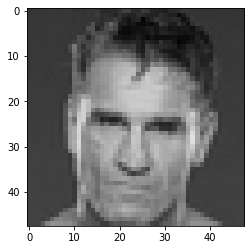

In [5]:
# import de l'image en couleur, conversion en greyscale, et transformation en vecteur numpy (greyscale: une dimension)
my_ima = np.asarray(Image.open('/home/romain/jupyter_mla/shamrock.jpg').convert('L')).astype(np.float32)
# conversion en image noir et blanc et sauvegarde
print('The original image dimension is ', my_ima.shape)
my_ima_pic = Image.fromarray(np.uint8(my_ima))
my_ima_pic.save('/home/romain/jupyter_mla/adv_romain_legrand_ori.png')
# aperçu de l'image
plt.imshow(my_ima, cmap='gray',clim=(0,255))
# création du label correspondant
my_lab = np.array([1,0])

### première prédiction

In [6]:
# fonction de prédiction pour la photo supplémentaire
def predict(data, label, model):
    pred = np.array(model(data, False))[0]
    print('score for gender = male is ' + str(round(pred[0],2)) + '; score for gender = female is ' \
          + str(round(pred[1],2)) + '.')
    pred_index = np.argmax(pred)
    if pred_index == 0:
        pred_gender = 'male'
    else:
        pred_gender = 'female'
    actual_index = np.argmax(label)
    if actual_index == 0:
        actual_gender = 'male'
    else:
        actual_gender = 'female'
    print('predicted gender is ' + pred_gender +', actual gender is ' + actual_gender + '.')
    if pred_gender == actual_gender:
        print('prediction is correct.')
    else:
        print('prediction is false.')
    return pred

In [7]:
# on fait la prédiction, qui doit normalement être correcte
predict1 = predict(my_ima, my_lab, simple_cnn)

score for gender = male is 20.42; score for gender = female is -13.37.
predicted gender is male, actual gender is male.
prediction is correct.


### création de l'image bruitée

Note: j'utilise la méthode "Fast Gradient Sign" de Goodfellow (2015) pour générer l'example adverse, dans la mesure où elle est beaucoup plus simple que celle qui consiste à entraîner la perturbation pour qu'elle maximise l'erreur.

In [8]:
# on va ici obtenir le gradient de la loss par rapport à l'image d'entrée
my_ima_ts = tf.convert_to_tensor(my_ima, np.float32)
my_lab_ts = tf.convert_to_tensor(my_lab, np.float32)
with tf.GradientTape() as t:
    t.watch(my_ima_ts)
    y = simple_cnn(my_ima_ts,False)
    y = tf.nn.log_softmax(y)
    diff = my_lab * y
    loss = -tf.reduce_sum(diff)
    grad = t.gradient(loss, my_ima_ts)

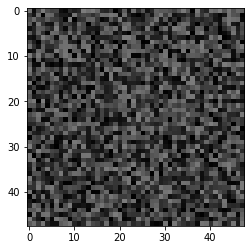

In [9]:
# intensité du bruit
int_bruit = 0.5
# copie de l'image originale
X = my_ima
# signe du gradient
grad = np.array(grad)
grad_sign = np.sign(grad)
# vecteur d'uniformes sur 0-2 pour avoir un bruit de 1 en moyenne 
unf = np.random.uniform(low=0.0, high=2.0, size=(48,48)).astype(np.float32)
# création de l'image de bruit
DX = int_bruit * grad_sign * unf
# transformation de l'image de bruit pour qu'elle soit d'avantage visible
DX_trans = 125 * np.absolute(DX)
# aperçu de l'image
plt.imshow(DX_trans , cmap='gray',clim=(0,255))
DX_pic = Image.fromarray(np.uint8(DX_trans))
# enregistrement de l'image de bruit
DX_pic.save('/home/romain/jupyter_mla/adv_romain_legrand_amp.png')

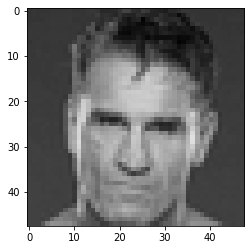

In [10]:
# création de l'image modififée avec le bruit
X_mod = X + DX
# on montre l'image bruitée, indiscernable de l'image originale
plt.imshow(X_mod, cmap='gray',clim=(0,255))
X_mod = np.reshape(X_mod, 2304)
# enregistrement de l'image de bruit
X_mod_pic = Image.fromarray(np.uint8(np.reshape(X_mod,(48,48))))
X_mod_pic.save('/home/romain/jupyter_mla/adv_romain_legrand_mod.png')

In [11]:
# on refait maintenant la prédiction, qui doit maintenant s'avérer fausse
predict2 = predict(X_mod, my_lab, simple_cnn)

score for gender = male is -26.0; score for gender = female is 37.02.
predicted gender is female, actual gender is male.
prediction is false.
